In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
from sklearn.linear_model import LogisticRegression


In [2]:
base_path = "/Users/andreasathanasopoulos/Phd/projects/bayesian_fairness/my_code/Bayesian-fairness/"
data_path = base_path + "/data"

In [3]:
!pwd

/Users/andreasathanasopoulos/Phd/projects/bayesian_fairness/my_code/Bayesian-fairness/src/notebooks/bayessian_fairness


# random P(z|x, y)

In [96]:
def get_multivariate_normal_params(n_x):
    A = np.random.rand(n_x,n_x)
    cov = np.matmul(A.T , A)
    mean = np.random.normal(size = n_x)
    return mean, cov

In [97]:
mean1

array([-0.90816589,  0.10293737])

In [136]:
N = 10000
mean1, cov1 = get_multivariate_normal_params(n_x=3)
mean2, cov2 = get_multivariate_normal_params(n_x=3)


In [140]:
cov2

array([[0.88981114, 1.21537513, 0.95397686],
       [1.21537513, 1.70606468, 1.20417589],
       [0.95397686, 1.20417589, 1.30863789]])

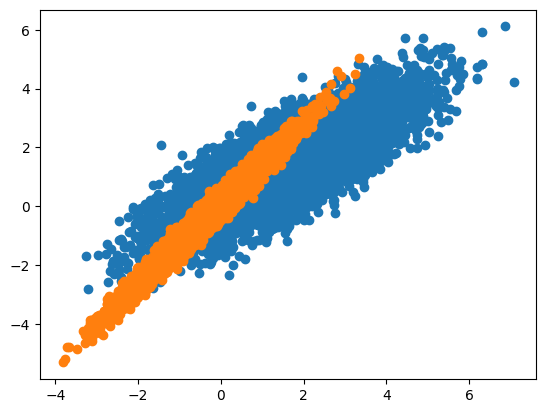

In [137]:
x1 = np.random.multivariate_normal(mean1, cov1, N)
x2 = np.random.multivariate_normal(mean2, cov2, N)

plt.scatter(x1[:,0], x1[:,1])
plt.scatter(x2[:,0], x2[:,1])

<AxesSubplot: ylabel='Density'>

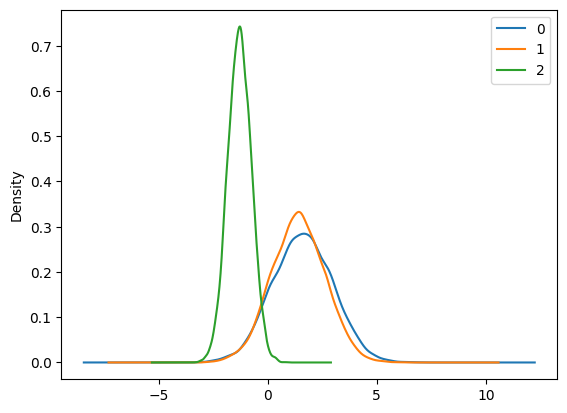

In [138]:
pd.DataFrame(x1).plot.kde()

<AxesSubplot: ylabel='Density'>

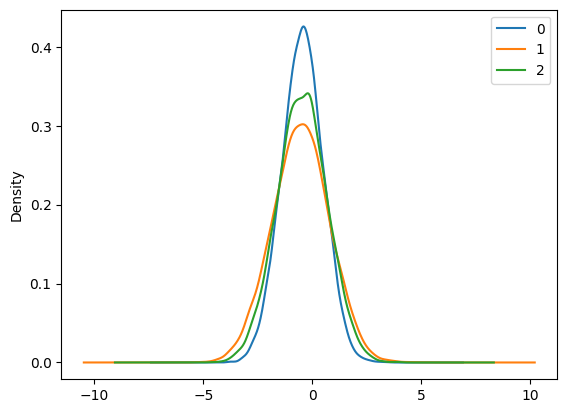

In [139]:
pd.DataFrame(x2).plot.kde()

In [125]:
def get_py_x(n_x, n_y):
    fake_samples = 1000
    fake_y = np.random.choice(range(n_y),
                              size = fake_samples)
    fake_x = np.random.normal(size = (fake_samples,n_x))
    
    model_y_x = LogisticRegression( n_jobs=-1)
    model_y_x.fit(fake_x, fake_y)

    init_weights = np.random.normal(0, 4, size= (1,n_x))
    model_y_x.coef_ = init_weights
    return model_y_x,init_weights

In [187]:
def get_pz_xy(n_x, n_y, n_z):
    fake_samples = 10000
    fake_y = np.random.choice(range(n_y), size = (fake_samples,1))
    fake_z = np.random.choice(range(n_z), size = fake_samples)
    fake_x = np.random.normal(size = (fake_samples, n_x))
    
    input_data = np.concatenate([fake_x, fake_y],axis=1)
    model_z_xy = LogisticRegression(n_jobs=-1)
    model_z_xy.fit(input_data, fake_z)

    init_weights = np.random.normal(0, 0.1, size= (1,input_data.shape[1]))
#     model_z_xy.coef_ = init_weights
    return model_z_xy,init_weights

In [188]:
# all together
def generate_data(N, mean, cov, model_y_x, model_z_xy):
    x = np.random.multivariate_normal(mean, cov, N)
    y = model_y_x.predict(x)
    y = np.reshape(y, (-1,1))
    z = model_z_xy.predict(np.concatenate([x, y], axis=1))
    z= np.reshape(z, (-1,1))
    return x,y,z
    
    
def get_train_test(num_training, num_test, n_x, n_y, n_z):
    X_atr = [f"x_{i}" for i in range(n_x)]
    Y_atr = ["y"]
    Z_atr = ["z"]
    
    mean, cov = get_multivariate_normal_params(n_x)
    model_y_x,  w = get_py_x(n_x,n_y)
    print(model_y_x.coef_)
    print(w)
    model_z_xy, w = get_pz_xy(n_x, n_y, n_z)
    print(model_z_xy.coef_)
    print(w)
    # generate train set
    train_data = generate_data(num_training, mean, cov, model_y_x, model_z_xy)
    train_data = pd.DataFrame(np.concatenate(train_data,axis=1), columns = X_atr + Y_atr + Z_atr)

    test_data = generate_data(num_test, mean, cov, model_y_x, model_z_xy)
    test_data = pd.DataFrame(np.concatenate(test_data,axis=1), columns =  X_atr + Y_atr + Z_atr)
    
    return train_data, test_data, model_z_xy

In [189]:
X_atr = [f"x_{i}" for i in range(n_x)]
Y_atr = ["y"]
Z_atr = ["z"]

In [190]:
n_x = 6
n_y = 2
n_z = 12
train_data, test_data, model = get_train_test(num_training=100, num_test=20000, n_x=n_x, n_y=n_y, n_z=n_z)

[[ 0.09087184  6.96909495 -4.60154826  1.06926298  4.97188602  5.8409658 ]]
[[ 0.09087184  6.96909495 -4.60154826  1.06926298  4.97188602  5.8409658 ]]
[[-0.03077221 -0.03726497 -0.01517064 -0.00984082 -0.02981446  0.02096449
  -0.03185423]
 [ 0.0119996   0.05608709 -0.03616648 -0.04745029 -0.00983658 -0.03306476
   0.00203344]
 [-0.00020651 -0.02595505  0.039492   -0.00814482 -0.01829294 -0.05537973
   0.15381104]
 [ 0.05005187 -0.0054858  -0.00300238  0.01197019  0.1033013  -0.0200414
  -0.05429005]
 [ 0.03325344 -0.01908154 -0.00215223  0.02036028 -0.07637198 -0.03289749
  -0.14737813]
 [-0.05124812 -0.04107837  0.01816703 -0.01924362  0.00739417 -0.01014373
   0.06957675]
 [-0.00344085  0.03587167  0.05013609  0.04246163 -0.03813008  0.01417863
  -0.01728458]
 [ 0.00606617 -0.017325    0.0045974  -0.04026496  0.01032104  0.02096206
  -0.0453054 ]
 [-0.03144327 -0.03437829 -0.02021517  0.00993109  0.05133079  0.03733193
  -0.0953171 ]
 [ 0.03447697 -0.03982769  0.0026171  -0.0128946

In [191]:
model.predict_proba(test_data[X_atr+Y_atr])

/Users/andreasathanasopoulos/Phd/projects/bayesian_fairness/envs/bayesian-fairness/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


array([[0.08557008, 0.08016865, 0.08456844, ..., 0.07746938, 0.08481324,
        0.09395512],
       [0.08220846, 0.07837515, 0.08340095, ..., 0.08174918, 0.08078647,
        0.09668631],
       [0.10953997, 0.08604451, 0.08190012, ..., 0.08432305, 0.05278261,
        0.07446718],
       ...,
       [0.09752373, 0.08434503, 0.07716095, ..., 0.08067934, 0.06717347,
        0.07929128],
       [0.09570338, 0.08609273, 0.07881725, ..., 0.07964138, 0.06730029,
        0.0793373 ],
       [0.10712837, 0.09201328, 0.0816445 , ..., 0.08205871, 0.05382617,
        0.07709964]])

In [192]:
train_data

,x_0,x_1,x_2,x_3,x_4,x_5,y,z
0,-0.017765,-1.040068,-0.090364,-2.002004,-0.875228,1.348637,0.0,7.0
1,-1.711405,-2.530160,-0.778155,-2.510680,-2.009783,-0.831784,0.0,5.0
2,-0.078476,-2.942972,0.097660,-3.321243,-2.493013,0.901082,0.0,7.0
3,-0.578914,0.216927,0.626412,-1.303111,-0.019238,1.193935,1.0,11.0
4,0.064439,-0.115299,2.086939,0.783343,0.642092,1.810427,1.0,6.0
...,...,...,...,...,...,...,...,...
95,0.090190,-0.233986,1.546585,-0.774993,0.056308,1.731672,1.0,5.0
96,-0.486212,-0.918331,0.203349,-1.416223,-0.661563,0.862194,0.0,7.0
97,-0.160264,0.061679,1.375236,-0.685146,0.207701,1.340067,1.0,5.0
98,0.525934,-0.047605,0.175924,-1.496239,-0.202079,3.688463,1.0,11.0


In [193]:
test_data.describe()

,x_0,x_1,x_2,x_3,x_4,x_5,y,z
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,-0.087071,-0.655940,0.668143,-1.413839,-0.504008,1.574486,0.457850,7.383250
std,1.121949,1.573507,1.383220,1.514532,1.463759,1.570468,0.498233,3.477438
min,-5.139791,-6.619494,-4.351979,-7.327321,-5.816125,-5.341019,0.000000,0.000000
25%,-0.848163,-1.731405,-0.272629,-2.457933,-1.500403,0.513334,0.000000,5.000000
50%,-0.088107,-0.646790,0.678572,-1.406667,-0.496588,1.573179,0.000000,7.000000
75%,0.672897,0.399005,1.601843,-0.382330,0.485706,2.623215,1.000000,11.000000
max,4.180668,5.379751,6.506822,4.629112,5.143229,7.686937,1.000000,11.000000


In [185]:
test_data["y"].value_counts()/test_data.shape[0]

1.0    0.70935
0.0    0.29065
Name: y, dtype: float64

In [174]:
mask = test_data["y"] == 0
z_y0 = test_data[mask][ "z"].value_counts()/sum(mask)

mask = test_data["y"] == 1
z_y1 = test_data[mask]["z"].value_counts()/sum(mask)

In [63]:
z_y0

1.0    0.926308
0.0    0.073692
Name: z, dtype: float64

In [64]:
z_y1

0.0    0.614243
1.0    0.385757
Name: z, dtype: float64

# load data

In [30]:
train_data, test_data, X_atr, Y_atr, Z_atr, n_y, n_z = get_continuous_compas_dataset(data_path=data_path)

NameError: name 'get_continuous_compas_dataset' is not defined

In [31]:
train_data.describe()

,x_0,x_1,x_2,x_3,x_4,x_5,y,z
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.702050,0.132958,1.003980,0.779969,0.092577,0.061878,0.540000,0.650000
std,1.406189,0.717188,2.090823,1.571090,1.492536,1.544257,0.500908,0.479372
min,-2.951914,-1.247113,-3.704258,-2.612321,-2.743671,-3.518966,0.000000,0.000000
25%,-0.053447,-0.306913,-0.383300,-0.200181,-0.763329,-0.983062,0.000000,0.000000
50%,0.719747,0.055365,0.905511,0.656549,-0.025113,0.144971,1.000000,1.000000
75%,1.459016,0.540132,2.265058,1.735874,0.838907,1.128989,1.000000,1.000000
max,5.970547,2.127088,6.906857,5.689705,5.265877,4.213941,1.000000,1.000000


In [11]:
print("training size:", train_data.shape)
print("testing size:", test_data.shape)

training size: (6000, 10)
testing size: (1214, 10)


# Discrete models

In [12]:
from src.continuous.models.models import get_models

In [13]:
Py, Pz_y, model_y_x, model_z_yx = get_models(data=train_data,
                                             X_atr=X_atr,
                                             Y_atr=Y_atr,
                                             Z_atr=Z_atr,
                                             n_y=n_y,
                                             n_z=n_z)

In [14]:
# generate y
train_data_y= np.random.binomial(n = 1, p = Py[1], size = (1000))

# generate p_z_y
train_data_z = np.random.multinomial(n=1, pvals= Pz_y[:,1], size = 1000 )

In [15]:
train_data["z"].unique()

array([ 0.,  1.,  2.,  8.,  3.,  7.,  6.,  9., 11.,  4.,  5., 10.],
      dtype=float32)

In [16]:
Pz_y[:,1]

array([0.03759259, 0.5087037 , 0.24166667, 0.06018519, 0.00240741,
       0.00240741, 0.00462963, 0.06981481, 0.06166667, 0.00944444,
       0.00055556, 0.00092593])

# Gan

In [19]:
def make_generator_model(latent_dim, x_dim):
    z = tf.keras.Input((latent_dim, ))
    x = tf.keras.layers.Dense(latent_dim/2, "relu")(z)
    x = tf.keras.layers.Dense(x_dim/2, "relu")(x)
    x = tf.keras.layers.Dense(x_dim, "relu")(x)
    generator = tf.keras.Model(z, x)
    return generator

In [20]:
def make_discriminator(x_dim):
    input_x = tf.keras.Input((x_dim, ))
    x = tf.keras.layers.Dense(x_dim/2, "relu")(input_x)
    x = tf.keras.layers.Dense(x_dim/2, "relu")(x)
    y = tf.keras.layers.Dense(x_dim, "sigmoid")(x)
    discriminator = tf.keras.Model(input_x, y)
    return discriminator

In [21]:
latent_dim = 20
x_dim = len(X_atr)
generator = make_generator_model(latent_dim, x_dim)
discriminator  = make_discriminator(x_dim)

cross_entropy = tf.keras.losses.BinaryCrossentropy()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
 dense_2 (Dense)             (None, 6)                 24        
                                                                 
Total params: 267
Trainable params: 267
Non-trainable params: 0
_________________________________________________________________


In [23]:
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 21        
                                                                 
 dense_4 (Dense)             (None, 3)                 12        
                                                                 
 dense_5 (Dense)             (None, 6)                 24        
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [24]:
noise = tf.random.normal([100, latent_dim])
generated_x = generator(noise, training=False)

In [25]:
tf.shape(noise)[0]

<tf.Tensor: shape=(), dtype=int32, numpy=100>

# Training loop

In [26]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss, fake_loss

gen_tracker = tf.keras.metrics.Mean(name="gen_loss")
disc_tracker = tf.keras.metrics.Mean(name="disc_loss")
disc_fake_tracker = tf.keras.metrics.Mean(name="disc_fake_loss")
disc_real_tracker = tf.keras.metrics.Mean(name="disc_real_loss")

class GanTrainer(tf.keras.Model):
    
    def __init__(self, discriminator, generator, latent_dim):
        super(GanTrainer, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
    
#     @tf.function
#     def eval_step(input_data):
#         BATCH_SIZE = tf.shape(input_data)[0]
#         noise = tf.random.normal([BATCH_SIZE, self.latent_dim])
        
#         generated_data = self.generator(noise, training=False)
        
#         real_output = self.discriminator(input_data, training=False)
#         fake_output = self.discriminator(generated_data, training=False)
        
#         gen_loss = generator_loss(fake_output)
#         disc_loss = discriminator_loss(real_output, fake_output)
        
    @tf.function
    def train_step(self, data):
        input_data, y = data
        BATCH_SIZE = tf.shape(input_data)[0]
        noise = tf.random.normal([BATCH_SIZE, self.latent_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_data = self.generator(noise, training=True)

            real_output = self.discriminator(input_data, training=True)
            fake_output = self.discriminator(generated_data, training=True)

            gen_loss = generator_loss(fake_output)
            real_loss, fake_loss = discriminator_loss(real_output, fake_output)
            disc_loss = real_loss + fake_loss


        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        gen_tracker.update_state(gen_loss)
        disc_tracker.update_state(disc_loss)
        disc_fake_tracker.update_state(fake_loss)
        disc_real_tracker.update_state(real_loss)
        
        metrics = {}
        metrics["gen_loss"] = gen_tracker.result()  
        metrics["disc_loss"] = disc_tracker.result()
        metrics["disc_fake_loss"] = disc_fake_tracker.result()
        metrics["disc_real_tracker"] = disc_real_tracker.result()
        
        return metrics
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [disc_tracker , gen_tracker]

In [27]:
gan_trainer = GanTrainer(generator=generator, discriminator=discriminator, latent_dim=latent_dim)
gan_trainer.compile()

In [28]:
hist = gan_trainer.fit(x=train_data[X_atr],
                       y=train_data[Y_atr],
                       batch_size=32,
                       shuffle=True,
                       epochs=200).history

Epoch 1/200


2023-02-15 14:20:36.267713: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


188/188 [==============================] - 1s 509us/step - gen_loss: 0.7046 - disc_loss: 1.3739 - disc_fake_loss: 0.6820 - disc_real_tracker: 0.6919
Epoch 2/200
188/188 [==============================] - 0s 465us/step - gen_loss: 0.7003 - disc_loss: 1.3762 - disc_fake_loss: 0.6841 - disc_real_tracker: 0.6904
Epoch 3/200
188/188 [==============================] - 0s 461us/step - gen_loss: 0.6998 - disc_loss: 1.3767 - disc_fake_loss: 0.6854 - disc_real_tracker: 0.6899
Epoch 4/200
188/188 [==============================] - 0s 996us/step - gen_loss: 0.7007 - disc_loss: 1.3752 - disc_fake_loss: 0.6858 - disc_real_tracker: 0.6897
Epoch 5/200
188/188 [==============================] - 0s 955us/step - gen_loss: 0.7023 - disc_loss: 1.3726 - disc_fake_loss: 0.6857 - disc_real_tracker: 0.6895
Epoch 6/200
188/188 [==============================] - 0s 458us/step - gen_loss: 0.7050 - disc_loss: 1.3685 - disc_fake_loss: 0.6853 - disc_real_tracker: 0.6891
Epoch 7/200
188/188 [=========================

188/188 [==============================] - 0s 482us/step - gen_loss: 0.6724 - disc_loss: 1.4206 - disc_fake_loss: 0.6450 - disc_real_tracker: 0.6618
Epoch 102/200
188/188 [==============================] - 0s 484us/step - gen_loss: 0.6815 - disc_loss: 1.4078 - disc_fake_loss: 0.6457 - disc_real_tracker: 0.6621
Epoch 103/200
188/188 [==============================] - 0s 475us/step - gen_loss: 0.6940 - disc_loss: 1.3922 - disc_fake_loss: 0.6462 - disc_real_tracker: 0.6625
Epoch 104/200
188/188 [==============================] - 0s 476us/step - gen_loss: 0.7018 - disc_loss: 1.3826 - disc_fake_loss: 0.6467 - disc_real_tracker: 0.6627
Epoch 105/200
188/188 [==============================] - 0s 473us/step - gen_loss: 0.7043 - disc_loss: 1.3752 - disc_fake_loss: 0.6471 - disc_real_tracker: 0.6630
Epoch 106/200
188/188 [==============================] - 0s 496us/step - gen_loss: 0.7016 - disc_loss: 1.3736 - disc_fake_loss: 0.6475 - disc_real_tracker: 0.6632
Epoch 107/200
188/188 [=============

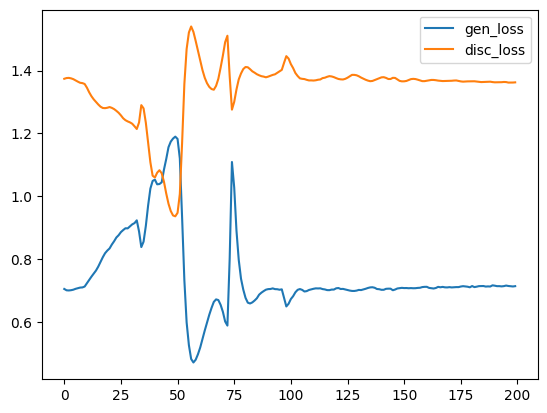

In [29]:
hist
plt.plot(hist['gen_loss'], label = "gen_loss")
plt.plot(hist['disc_loss'], label = "disc_loss")
plt.legend()
plt.show()
plt.close()

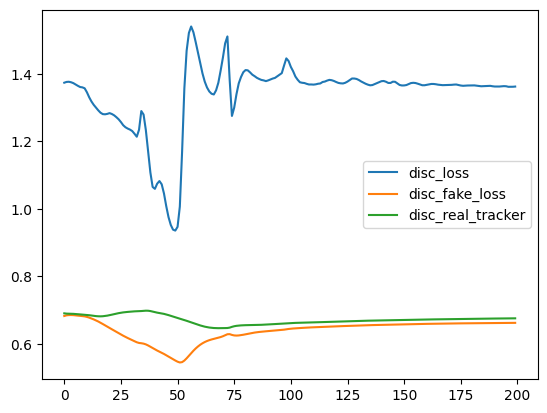

In [30]:
hist
plt.plot(hist['disc_loss'], label = "disc_loss")
plt.plot(hist['disc_fake_loss'], label = "disc_fake_loss")
plt.plot(hist['disc_real_tracker'], label = "disc_real_tracker")
plt.legend()
plt.show()
plt.close()

# viz evaluation

In [39]:
unique = {}
for feature in X_atr:
    unique[feature] = train_data[feature].unique()

In [40]:
unique

{'age_cat': array([2., 1., 0.], dtype=float32),
 'juv_fel_count': array([ 0.,  2.,  1.,  8.,  4.,  3.,  9., 20.,  6.,  5., 10.],
       dtype=float32),
 'juv_misd_count': array([ 0.,  1.,  6., 12.,  2.,  4.,  3.,  8.,  5., 13.], dtype=float32),
 'juv_other_count': array([ 0.,  1.,  2.,  3.,  4., 17.,  9.,  5.,  6.,  7.], dtype=float32),
 'priors_count': array([ 0.,  4.,  1.,  2., 14.,  3.,  7.,  6.,  5., 13.,  8.,  9., 21.,
        20., 15., 10., 12., 28., 19., 11., 22., 23., 25., 24., 36., 18.,
        16., 33., 17., 30., 27., 38., 26., 37., 29., 35., 31.],
       dtype=float32),
 'c_charge_degree': array([1., 0.], dtype=float32)}

In [31]:
noise = tf.random.normal([100, latent_dim])
generated_x = generator(noise, training=False)
generated_data = pd.DataFrame(generated_x,columns=X_atr)

<AxesSubplot: ylabel='Density'>

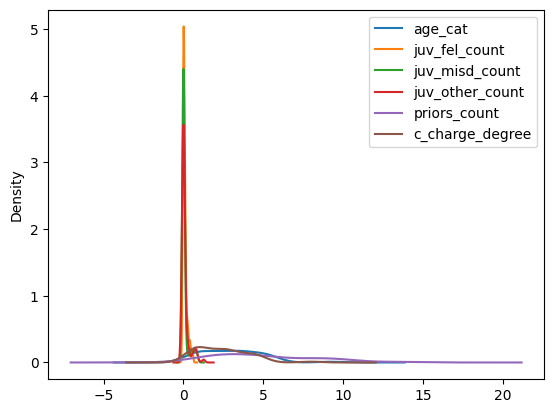

In [32]:
generated_data[X_atr].plot.kde()

<AxesSubplot: ylabel='Density'>

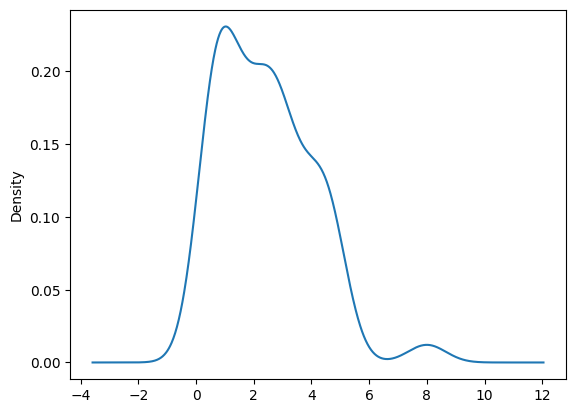

In [36]:
generated_data[feature].plot.kde(label="generated")

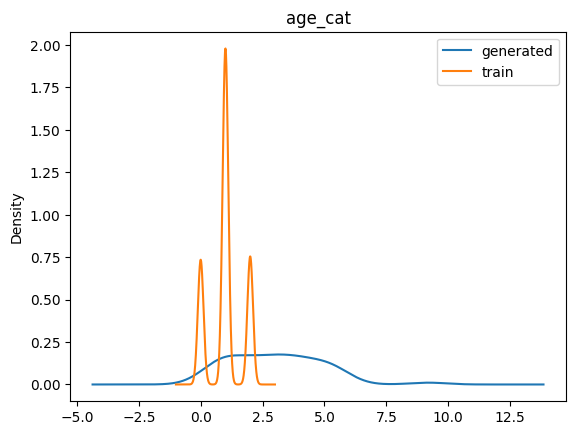

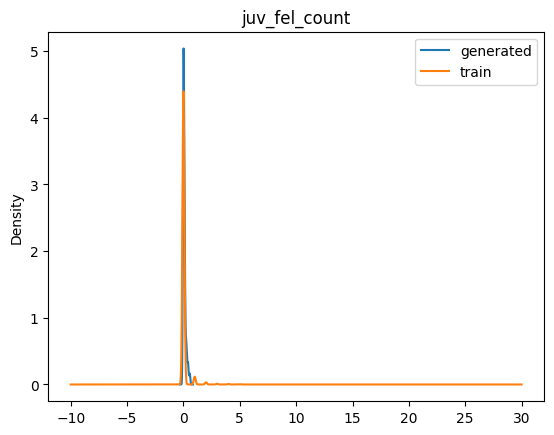

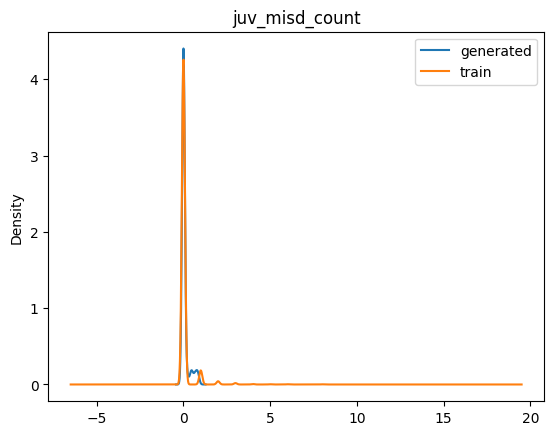

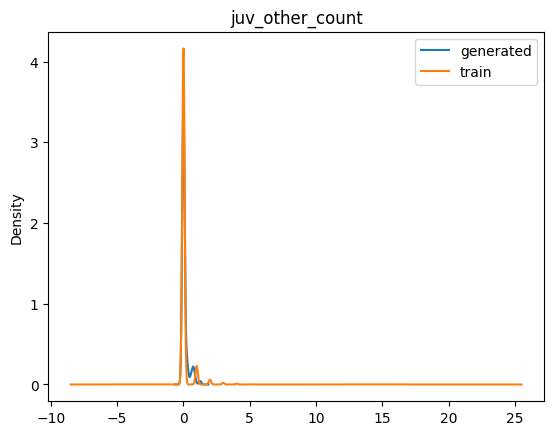

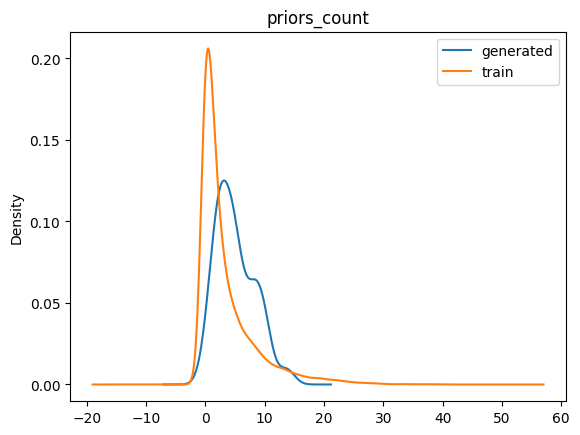

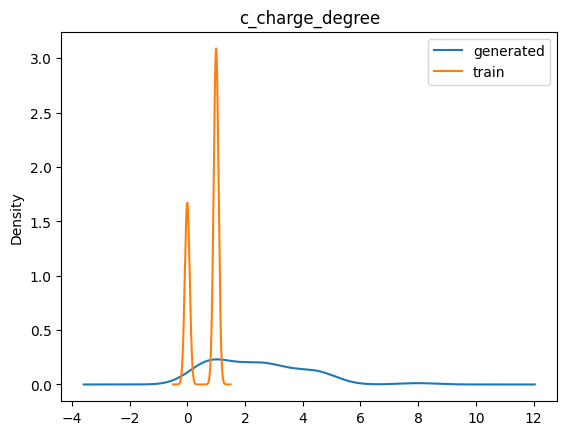

In [38]:
for feature in X_atr:
    plt.figure()
    generated_data[feature].plot.kde(label="generated")
    train_data[feature].plot.kde(label="train")
    plt.title(feature)
    plt.legend()
    plt.show()
    plt.close()

In [193]:
generated_data

,age_cat,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree
0,0.0,10.315630,0.000000,9.706468,0.000000,0.0
1,0.0,0.000000,5.454772,2.002204,17.062330,0.0
2,0.0,12.930139,0.000000,13.500210,0.000000,0.0
3,0.0,0.000000,15.172934,14.276008,25.890448,0.0
4,0.0,0.000000,4.442349,9.343571,1.863032,0.0
...,...,...,...,...,...,...
95,0.0,14.454542,0.000000,14.018885,0.000000,0.0
96,0.0,13.919475,1.244239,21.704508,0.000000,0.0
97,0.0,23.974848,0.000000,26.255964,0.000000,0.0
98,0.0,16.090891,0.000000,14.764149,0.000000,0.0


In [194]:
generated_data.describe()

,age_cat,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree
count,100.0,100.000000,100.000000,100.000000,100.000000,100.0
mean,0.0,7.574506,2.455076,11.081705,4.189482,0.0
std,0.0,9.349852,3.147698,10.734447,6.230231,0.0
min,0.0,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.0,0.000000,0.000000,2.005122,0.000000,0.0
50%,0.0,4.014022,0.918243,8.670630,1.112883,0.0
75%,0.0,12.965807,4.524726,16.687838,5.949774,0.0
max,0.0,36.241627,15.172934,47.051430,29.158590,0.0


In [195]:
train_data[X_atr].describe()

,age_cat,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,-0.001293,0.001624,0.002883,-0.001404,-0.001963,0.004607
std,0.998840,1.042430,1.034298,1.005314,0.997992,0.998657
min,-1.534260,-0.141855,-0.187414,-0.218065,-0.711240,-1.353233
25%,-0.009931,-0.141855,-0.187414,-0.218065,-0.711240,-1.353233
50%,-0.009931,-0.141855,-0.187414,-0.218065,-0.301588,0.738971
75%,-0.009931,-0.141855,-0.187414,-0.218065,0.312889,0.738971
max,1.514398,42.057697,26.605391,33.676788,7.072136,0.738971


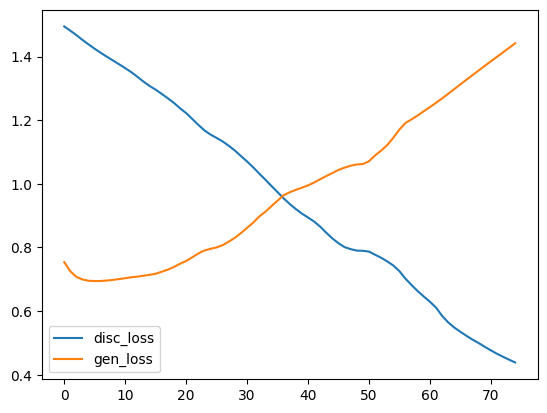

In [175]:
hist
plt.plot(hist['disc_loss'], label = "disc_loss")
plt.plot(hist['gen_loss'], label = "gen_loss")
plt.legend()
plt.show()
plt.close()

In [64]:
noise = tf.random.normal([100, latent_dim])
generated_x = generator(noise, training=False)

<AxesSubplot: ylabel='Density'>

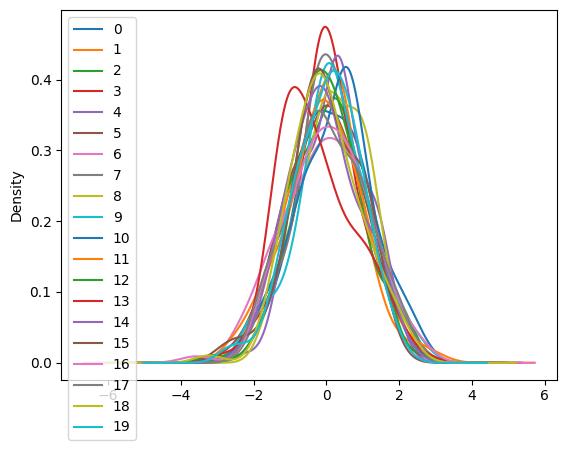

In [65]:
pd.DataFrame(noise).plot.kde()

In [66]:
pd.DataFrame(generated_x).describe()

,0,1,2,3,4,5
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.003112,0.070236,0.008674,0.943847,0.932123,0.309715
std,0.012306,0.080932,0.032889,0.976649,1.041949,0.369886
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.001819,0.000000,0.123816,0.015237,0.000000
50%,0.000000,0.044996,0.000000,0.629784,0.562222,0.164797
75%,0.000000,0.108645,0.000000,1.469490,1.368720,0.496185
max,0.084562,0.415466,0.232838,3.992156,4.240798,1.644156


<AxesSubplot: ylabel='Density'>

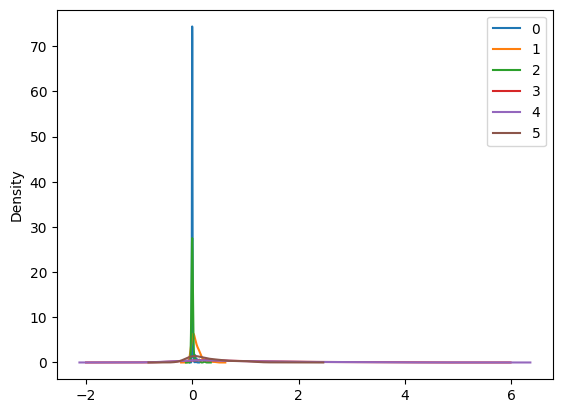

In [67]:
pd.DataFrame(generated_x).plot.kde()

<AxesSubplot: ylabel='Density'>

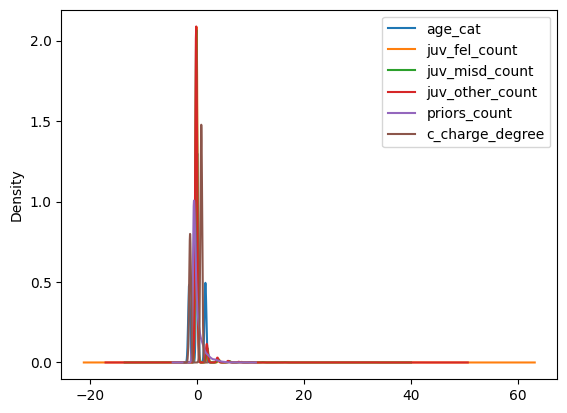

In [68]:
train_data[X_atr].plot.kde()

LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

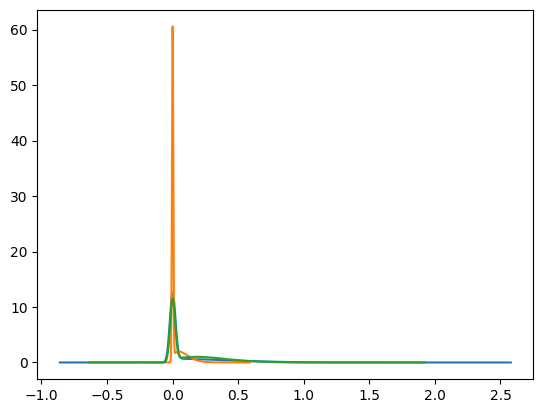

In [35]:
pd.DataFrame(generated_x).plot.kde()

In [18]:
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 3)                 9         
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
 dense_2 (Dense)             (None, 6)                 24        
                                                                 
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


In [20]:
input_x = tf.keras.Input((6, ))
x = tf.keras.layers.Dense(3, "relu")
x = tf.keras.layers.Dense(3, "relu")(x)
z = tf.keras.layers.Dense(2, "relu")

In [21]:
tf.keras.layers.Dense(3, "relu")